# Amazon Product Reviews - Sentiment Analysis

## 🎯 Project Objective

This project compares **classical machine learning** (Logistic Regression with TF-IDF) against **modern deep learning** (DistilBERT transformer) for sentiment classification on Amazon product reviews.

**Key Question**: Does the added complexity of transformer models provide significant performance gains for binary sentiment analysis?

### Dataset
- **Source**: Amazon Product Reviews (568,454 total reviews)
- **Task**: Binary sentiment classification (Positive/Negative)
- **Approach**: Fair comparison with both models evaluated on identical test sets

### Why This Comparison Matters
- Logistic Regression: Fast, interpretable, resource-efficient
- DistilBERT: State-of-the-art NLP, context-aware, computationally expensive
- Understanding the trade-offs helps choose the right tool for production systems


## Project Overview
This notebook performs sentiment analysis on Amazon product reviews using two different approaches:
1. **Traditional ML**: Logistic Regression with TF-IDF features (10k dataset)
2. **Deep Learning**: BERT-based transformer model (28k dataset)
3. **Fair Comparison**: Both models evaluated on same test set

Both models classify reviews as Positive (score ≥ 3) or Negative (score < 3).

## 1. Setup and Imports

In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
from textblob import TextBlob

# Sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# NLTK
from nltk.corpus import stopwords

# Set display options
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 2. Data Loading and Exploration

### 2.1 Load Dataset

In [171]:
df = pd.read_csv("/kaggle/input/amazon-product-reviews/Reviews.csv")
print(f"Dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")

Dataset loaded: 568,454 rows, 10 columns


### 2.2 Balance Dataset

To address class imbalance, we sample 10,000 reviews from each score category (1-5 stars).

In [172]:
df["NScore"] = df["Score"].apply(lambda x: 1 if x >= 3 else 0)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,NScore
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of ...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelati...",1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got thi...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very qu...,1


In [173]:
df = df.groupby('NScore').apply(lambda x: x.sample(25000)).reset_index(drop=True)
print(f"Balanced dataset: {df.shape[0]:,} rows")

Balanced dataset: 50,000 rows


/tmp/ipykernel_47/1838680739.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('NScore').apply(lambda x: x.sample(25000)).reset_index(drop=True)


### 2.3 Dataset Overview

In [174]:
df.shape

(50000, 11)

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      50000 non-null  int64 
 1   ProductId               50000 non-null  object
 2   UserId                  50000 non-null  object
 3   ProfileName             49997 non-null  object
 4   HelpfulnessNumerator    50000 non-null  int64 
 5   HelpfulnessDenominator  50000 non-null  int64 
 6   Score                   50000 non-null  int64 
 7   Time                    50000 non-null  int64 
 8   Summary                 49995 non-null  object
 9   Text                    50000 non-null  object
 10  NScore                  50000 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 4.2+ MB


## 3. Feature Engineering and EDA

### 3.1 Time-based Features

In [176]:
df["Time"] = pd.to_datetime(df["Time"], unit="s")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,NScore
0,36674,B004CLCEDE,A3J0T442C0D4C1,O. Marko,7,9,1,2011-06-25,Not What I Was Expecting,"I try to maintain a low carb diet most of the time, and was excited to find these. When I tried ...",0
1,334998,B003D4MW38,AUYG6HXXGZOG0,Edward,6,9,1,2010-11-12,TOTALLY MISLEADING,Totally misleading; where do i begin.<br /><br />It is not GOJI BERRY like the heading implies; ...,0
2,491752,B004RVIPCI,AUAGV8KH223A3,ninomonique,1,1,1,2011-08-08,Terrible,I just bought a bottle of La Choy Stir Fry Sauce (Original) and what a waste of money!!! The goo...,0
3,324338,B000LKZ9IC,AZ2NZWEEPJ1JZ,ChiliPep123,38,53,1,2009-10-14,Contains BPA!,I love Muir Glen tomato products but sadly I had to give them up due to their can liners contain...,0
4,118219,B002QTWUEC,AZ2095SWQ7ITT,DoberDane Girl,0,0,1,2012-09-14,Mylar balloon flavored graham crackers.,"I am a fan of this brand, but was extremely disappointed when I tried the Bunny Graham Friends. ...",0


In [177]:
df["Year"] = df["Time"].dt.year
df["Month"] = df["Time"].dt.month_name()
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,NScore,Year,Month
0,36674,B004CLCEDE,A3J0T442C0D4C1,O. Marko,7,9,1,2011-06-25,Not What I Was Expecting,"I try to maintain a low carb diet most of the time, and was excited to find these. When I tried ...",0,2011,June
1,334998,B003D4MW38,AUYG6HXXGZOG0,Edward,6,9,1,2010-11-12,TOTALLY MISLEADING,Totally misleading; where do i begin.<br /><br />It is not GOJI BERRY like the heading implies; ...,0,2010,November
2,491752,B004RVIPCI,AUAGV8KH223A3,ninomonique,1,1,1,2011-08-08,Terrible,I just bought a bottle of La Choy Stir Fry Sauce (Original) and what a waste of money!!! The goo...,0,2011,August
3,324338,B000LKZ9IC,AZ2NZWEEPJ1JZ,ChiliPep123,38,53,1,2009-10-14,Contains BPA!,I love Muir Glen tomato products but sadly I had to give them up due to their can liners contain...,0,2009,October
4,118219,B002QTWUEC,AZ2095SWQ7ITT,DoberDane Girl,0,0,1,2012-09-14,Mylar balloon flavored graham crackers.,"I am a fan of this brand, but was extremely disappointed when I tried the Bunny Graham Friends. ...",0,2012,September


### 3.2 Helpfulness Score

In [178]:
df["Helpful"] = np.where(
    df["HelpfulnessDenominator"] == 0,
    np.nan,
    df["HelpfulnessNumerator"] / df["HelpfulnessDenominator"]
)
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,NScore,Year,Month,Helpful
0,36674,B004CLCEDE,A3J0T442C0D4C1,O. Marko,7,9,1,2011-06-25,Not What I Was Expecting,"I try to maintain a low carb diet most of the time, and was excited to find these. When I tried ...",0,2011,June,0.777778
1,334998,B003D4MW38,AUYG6HXXGZOG0,Edward,6,9,1,2010-11-12,TOTALLY MISLEADING,Totally misleading; where do i begin.<br /><br />It is not GOJI BERRY like the heading implies; ...,0,2010,November,0.666667
2,491752,B004RVIPCI,AUAGV8KH223A3,ninomonique,1,1,1,2011-08-08,Terrible,I just bought a bottle of La Choy Stir Fry Sauce (Original) and what a waste of money!!! The goo...,0,2011,August,1.000000
3,324338,B000LKZ9IC,AZ2NZWEEPJ1JZ,ChiliPep123,38,53,1,2009-10-14,Contains BPA!,I love Muir Glen tomato products but sadly I had to give them up due to their can liners contain...,0,2009,October,0.716981
4,118219,B002QTWUEC,AZ2095SWQ7ITT,DoberDane Girl,0,0,1,2012-09-14,Mylar balloon flavored graham crackers.,"I am a fan of this brand, but was extremely disappointed when I tried the Bunny Graham Friends. ...",0,2012,September,NaN


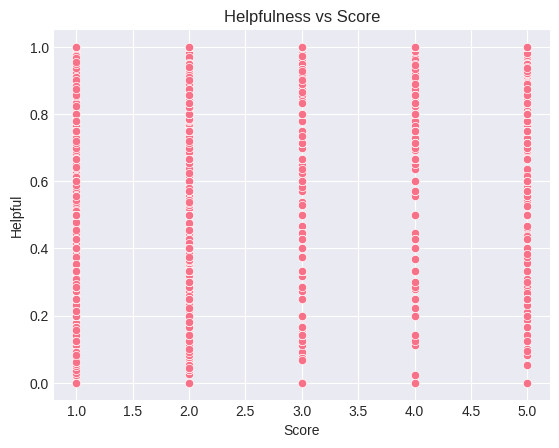

In [179]:
sns.scatterplot(data=df, x="Score", y="Helpful")
plt.title("Helpfulness vs Score")
plt.show()

**Observation**: The Helpfulness score shows no clear relationship with review Score, making it a weak indicator for sentiment prediction.

### 3.3 Review Length Analysis

In [180]:
df["ReviewLen"] = df["Text"].apply(lambda x: len(x))
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,NScore,Year,Month,Helpful,ReviewLen
0,36674,B004CLCEDE,A3J0T442C0D4C1,O. Marko,7,9,1,2011-06-25,Not What I Was Expecting,"I try to maintain a low carb diet most of the time, and was excited to find these. When I tried ...",0,2011,June,0.777778,492
1,334998,B003D4MW38,AUYG6HXXGZOG0,Edward,6,9,1,2010-11-12,TOTALLY MISLEADING,Totally misleading; where do i begin.<br /><br />It is not GOJI BERRY like the heading implies; ...,0,2010,November,0.666667,836
2,491752,B004RVIPCI,AUAGV8KH223A3,ninomonique,1,1,1,2011-08-08,Terrible,I just bought a bottle of La Choy Stir Fry Sauce (Original) and what a waste of money!!! The goo...,0,2011,August,1.000000,504
3,324338,B000LKZ9IC,AZ2NZWEEPJ1JZ,ChiliPep123,38,53,1,2009-10-14,Contains BPA!,I love Muir Glen tomato products but sadly I had to give them up due to their can liners contain...,0,2009,October,0.716981,1323
4,118219,B002QTWUEC,AZ2095SWQ7ITT,DoberDane Girl,0,0,1,2012-09-14,Mylar balloon flavored graham crackers.,"I am a fan of this brand, but was extremely disappointed when I tried the Bunny Graham Friends. ...",0,2012,September,NaN,710


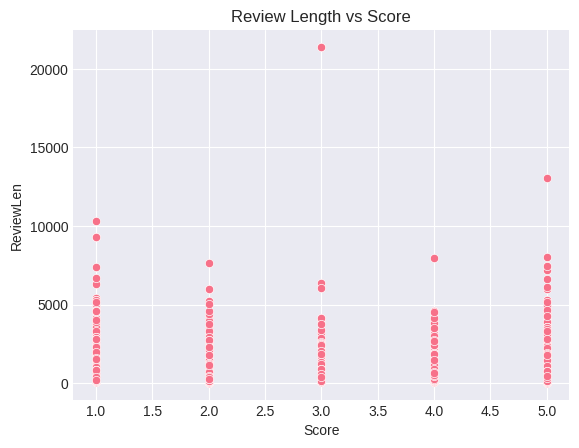

In [181]:
sns.scatterplot(data=df, x="Score", y="ReviewLen")
plt.title("Review Length vs Score")
plt.show()

**Observation**: Review length also shows no clear correlation with sentiment, though negative reviews tend to be longer on average.

### 3.4 Polarity Feature (TextBlob)

In [182]:
df["Summary"].fillna('', inplace=True)

/tmp/ipykernel_47/1524685250.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Summary"].fillna('', inplace=True)


In [183]:
def get_pol(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    pol = textblob.sentiment.polarity 
    return pol

df["Polarity"] = df["Summary"].apply(get_pol)
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,NScore,Year,Month,Helpful,ReviewLen,Polarity
0,36674,B004CLCEDE,A3J0T442C0D4C1,O. Marko,7,9,1,2011-06-25,Not What I Was Expecting,"I try to maintain a low carb diet most of the time, and was excited to find these. When I tried ...",0,2011,June,0.777778,492,0.0
1,334998,B003D4MW38,AUYG6HXXGZOG0,Edward,6,9,1,2010-11-12,TOTALLY MISLEADING,Totally misleading; where do i begin.<br /><br />It is not GOJI BERRY like the heading implies; ...,0,2010,November,0.666667,836,0.0
2,491752,B004RVIPCI,AUAGV8KH223A3,ninomonique,1,1,1,2011-08-08,Terrible,I just bought a bottle of La Choy Stir Fry Sauce (Original) and what a waste of money!!! The goo...,0,2011,August,1.000000,504,-1.0
3,324338,B000LKZ9IC,AZ2NZWEEPJ1JZ,ChiliPep123,38,53,1,2009-10-14,Contains BPA!,I love Muir Glen tomato products but sadly I had to give them up due to their can liners contain...,0,2009,October,0.716981,1323,0.0
4,118219,B002QTWUEC,AZ2095SWQ7ITT,DoberDane Girl,0,0,1,2012-09-14,Mylar balloon flavored graham crackers.,"I am a fan of this brand, but was extremely disappointed when I tried the Bunny Graham Friends. ...",0,2012,September,NaN,710,0.0


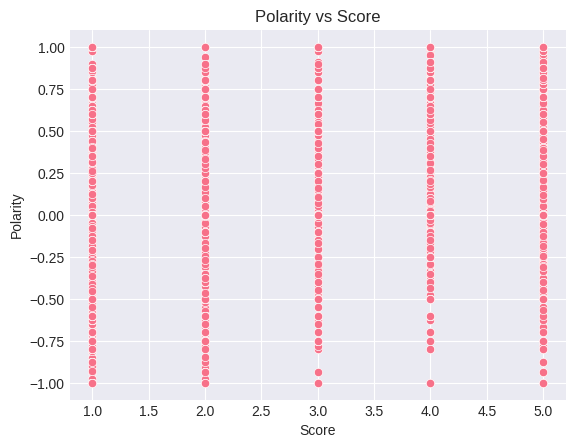

In [184]:
sns.scatterplot(data=df, x="Score", y="Polarity")
plt.title("Polarity vs Score")
plt.show()

**Observation**: TextBlob polarity from Summary doesn't provide strong separation between sentiment classes.

### 3.5 Create Binary Target Variable

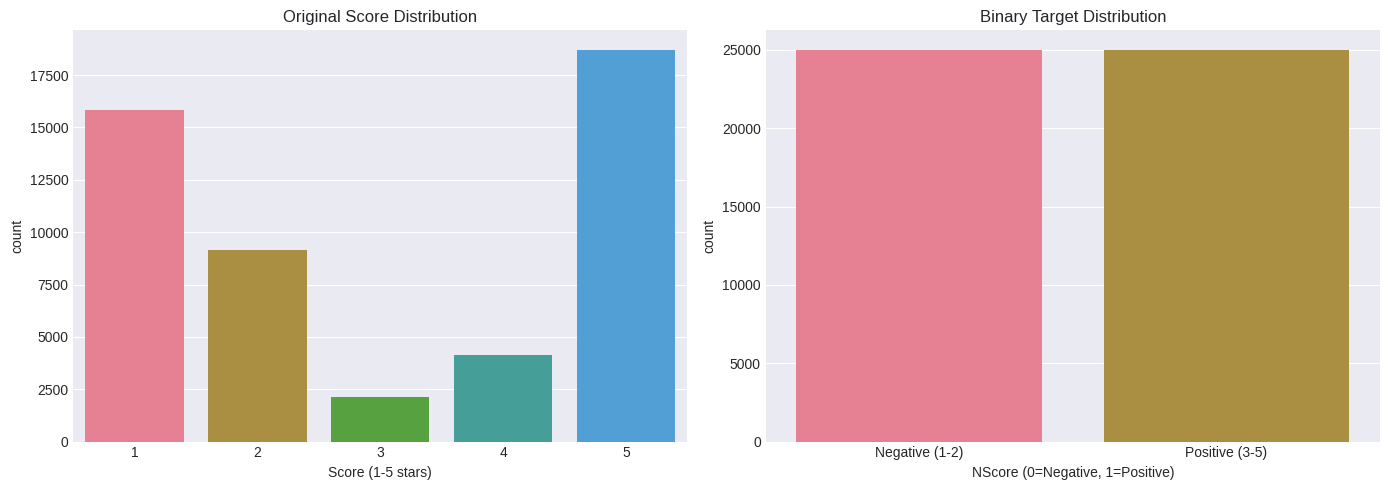

Negative reviews: 25000
Positive reviews: 25000


In [185]:
# Visualize target distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(data=df, x="Score", ax=ax[0])
ax[0].set_title("Original Score Distribution")
ax[0].set_xlabel("Score (1-5 stars)")

sns.countplot(data=df, x="NScore", ax=ax[1])
ax[1].set_title("Binary Target Distribution")
ax[1].set_xlabel("NScore (0=Negative, 1=Positive)")
ax[1].set_xticklabels(['Negative (1-2)', 'Positive (3-5)'])

plt.tight_layout()
plt.show()

print(f"Negative reviews: {(df['NScore']==0).sum()}")
print(f"Positive reviews: {(df['NScore']==1).sum()}")

**Note**: After sampling 10k from each Score category, we have balanced binary classes (20k negative, 30k positive).

### 3.6 Product Analysis

In [186]:
(df.groupby("ProductId")["Text"].count() == 1).sum()

13499

In [187]:
len(df["ProductId"].unique())

20912

Approximately 40% of products have only one review, which is important for recommendation system considerations.

## 4. Text Preprocessing

### 4.1 Text Analysis

In [188]:
hashTags=df['Text'].str.extractall(r"(#\S+)")
hashTags = hashTags[0].value_counts()
hashTags[:50]

0
#1                      75
#2                      27
#9827;                  11
#7                      11
#4                      10
#40                     10
#5                       9
#3                       9
#2,                      8
#6,                      5
#1.                      5
#8                       5
#6.<br                   5
#5,                      4
#2.                      4
#6                       4
#10                      3
#31105;&#31859;),        3
#40.                     3
#40,                     3
#12                      3
#9                       2
#1:                      2
#4....an                 2
#.                       2
#9827;&#9827;&#9827;     2
#9824;                   2
#FAIL                    2
#7:                      2
#3.                      2
#8230;]<br               2
#5PP                     2
#8203;&#8203;to          2
#1,                      2
#<br                     2
#8230;]).                2
#3.<br                   2

In [189]:
mentions = df['Text'].str.extractall(r"(@\S+)")
mentions = mentions[0].value_counts()
mentions[:50]

0
@hotmail.com                3
@#$%ING                     2
@yahoo.com                  2
@aol.com                    2
@10pm                       2
@$$Y!                       1
@5t@rD                      1
@insightbb.com              1
@7am                        1
@gmail.com.                 1
@almostedenplants.com<br    1
@mouthful                   1
@honeyvillegrain.com<br     1
@20                         1
@mchsi.com                  1
@5                          1
@OrchardFruit].<br          1
@gmail.com                  1
@eskimo.com                 1
@%*$@!                      1
@p,                         1
@$23.99                     1
@*&                         1
@Amazon                     1
@HonestOmnivore             1
Name: count, dtype: int64

In [190]:
df["Text"].str.count("<br />").sum()

61183

### 4.2 Text Cleaning Function

In [191]:
import re

def clean(text):
    text = re.sub(r'http\S+', " ", text)
    text = re.sub(r'@\w+',' ',text)
    text = re.sub(r'#\w+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    return text.lower()

### 4.3 Apply Cleaning

In [192]:
x = df["Text"].apply(clean)
x

0        i try to maintain a low carb diet most of the time, and was excited to find these. when i tried ...
1        totally misleading; where do i begin.  it is not goji berry like the heading implies; rather, it...
2        i just bought a bottle of la choy stir fry sauce (original) and what a waste of money!!! the goo...
3        i love muir glen tomato products but sadly i had to give them up due to their can liners contain...
4        i am a fan of this brand, but was extremely disappointed when i tried the bunny graham friends. ...
                                                        ...                                                 
49995    a friend of mine had just bought this for her dog who seemed to find it challenging and recommen...
49996    i have a mini-schnauzer that cannot have over  % fat or it will make him very sick. these treats...
49997    i bought four of these for gifts; all the recipiants were pleased with them and complimented the...
49998    i bought i

In [193]:
df["Text"] = x
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,NScore,Year,Month,Helpful,ReviewLen,Polarity
0,36674,B004CLCEDE,A3J0T442C0D4C1,O. Marko,7,9,1,2011-06-25,Not What I Was Expecting,"i try to maintain a low carb diet most of the time, and was excited to find these. when i tried ...",0,2011,June,0.777778,492,0.0
1,334998,B003D4MW38,AUYG6HXXGZOG0,Edward,6,9,1,2010-11-12,TOTALLY MISLEADING,"totally misleading; where do i begin. it is not goji berry like the heading implies; rather, it...",0,2010,November,0.666667,836,0.0
2,491752,B004RVIPCI,AUAGV8KH223A3,ninomonique,1,1,1,2011-08-08,Terrible,i just bought a bottle of la choy stir fry sauce (original) and what a waste of money!!! the goo...,0,2011,August,1.000000,504,-1.0
3,324338,B000LKZ9IC,AZ2NZWEEPJ1JZ,ChiliPep123,38,53,1,2009-10-14,Contains BPA!,i love muir glen tomato products but sadly i had to give them up due to their can liners contain...,0,2009,October,0.716981,1323,0.0
4,118219,B002QTWUEC,AZ2095SWQ7ITT,DoberDane Girl,0,0,1,2012-09-14,Mylar balloon flavored graham crackers.,"i am a fan of this brand, but was extremely disappointed when i tried the bunny graham friends. ...",0,2012,September,NaN,710,0.0


### 4.4 Lemmatization with Spacy

In [194]:
import spacy

In [195]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

cleaned_text = []
for doc in list(nlp.pipe(df["Text"], batch_size=64)):
    tokens = []

    for token in doc:
        if token.is_stop or token.is_punct or not token.is_alpha:
            continue
        tokens.append(token.lemma_.lower())

    cleaned_text.append(' '.join(tokens))

print(f"Processed {len(cleaned_text)} texts")

Processed 50000 texts


In [196]:
df["CleanedText"] = cleaned_text

In [197]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,NScore,Year,Month,Helpful,ReviewLen,Polarity,CleanedText
0,36674,B004CLCEDE,A3J0T442C0D4C1,O. Marko,7,9,1,2011-06-25,Not What I Was Expecting,"i try to maintain a low carb diet most of the time, and was excited to find these. when i tried ...",0,2011,June,0.777778,492,0.0,try maintain low carb diet time excited find try think absolutely horrible past smell bad past f...
1,334998,B003D4MW38,AUYG6HXXGZOG0,Edward,6,9,1,2010-11-12,TOTALLY MISLEADING,"totally misleading; where do i begin. it is not goji berry like the heading implies; rather, it...",0,2010,November,0.666667,836,0.0,totally misleading begin goji berry like heading imply goji flavor furthermore lot ingredient ti...
2,491752,B004RVIPCI,AUAGV8KH223A3,ninomonique,1,1,1,2011-08-08,Terrible,i just bought a bottle of la choy stir fry sauce (original) and what a waste of money!!! the goo...,0,2011,August,1.000000,504,-1.0,buy bottle la choy stir fry sauce original waste money good news decide try add meat veggie disb...
3,324338,B000LKZ9IC,AZ2NZWEEPJ1JZ,ChiliPep123,38,53,1,2009-10-14,Contains BPA!,i love muir glen tomato products but sadly i had to give them up due to their can liners contain...,0,2009,October,0.716981,1323,0.0,love muir glen tomato product sadly liner contain bisphenol bpa feed anymore bpa kid make sick f...
4,118219,B002QTWUEC,AZ2095SWQ7ITT,DoberDane Girl,0,0,1,2012-09-14,Mylar balloon flavored graham crackers.,"i am a fan of this brand, but was extremely disappointed when i tried the bunny graham friends. ...",0,2012,September,NaN,710,0.0,fan brand extremely disappointed try bunny graham friend notice immediately open brand new box s...


## 5. Model 1: Logistic Regression with TF-IDF

### 5.1 Train-Test Split

In [198]:
from sklearn.model_selection import train_test_split

X = df.CleanedText
y = df.NScore

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.05, random_state=42, shuffle=True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.05, random_state=42, shuffle=True, stratify=y_train_val)

In [199]:
X_train.shape

(45125,)

In [200]:
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nClass distribution in training:")
print(y_train.value_counts())

Training set: 45125 samples
Validation set: 2375 samples
Test set: 2500 samples

Class distribution in training:
NScore
1    22563
0    22562
Name: count, dtype: int64


### 5.2 TF-IDF Vectorization

In [201]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [202]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), min_df=3)

X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

In [203]:
print(f"TF-IDF Features created: {X_train_vec.shape[1]}")
print(f"Feature matrix shape: {X_train_vec.shape}")

TF-IDF Features created: 113544
Feature matrix shape: (45125, 113544)


### 5.3 Train Logistic Regression

In [204]:
from sklearn.linear_model import LogisticRegression

In [205]:
lr = LogisticRegression(random_state=42, class_weight="balanced")

In [206]:
model = lr.fit(X_train_vec, y_train)

In [207]:
print("✓ Logistic Regression model trained successfully")

✓ Logistic Regression model trained successfully


### 5.4 Model Evaluation

In [208]:
# Make predictions
y_train_pred = model.predict(X_train_vec)
y_val_pred = model.predict(X_val_vec)
y_test_pred = model.predict(X_test_vec)

# Get probabilities for ROC curve
y_train_proba = model.predict_proba(X_train_vec)[:, 1]
y_val_proba = model.predict_proba(X_val_vec)[:, 1]
y_test_proba = model.predict_proba(X_test_vec)[:, 1]

print("✓ Predictions completed")

✓ Predictions completed


#### Training Set Performance

In [209]:
from sklearn.metrics import classification_report

print(classification_report(y_train, model.predict(X_train_vec)))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92     22562
           1       0.92      0.91      0.92     22563

    accuracy                           0.92     45125
   macro avg       0.92      0.92      0.92     45125
weighted avg       0.92      0.92      0.92     45125



#### Validation Set Performance

In [210]:
print(classification_report(y_val, model.predict(X_val_vec)))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1188
           1       0.86      0.87      0.86      1187

    accuracy                           0.86      2375
   macro avg       0.86      0.86      0.86      2375
weighted avg       0.86      0.86      0.86      2375



#### Test Set Performance

In [211]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1250
           1       0.86      0.86      0.86      1250

    accuracy                           0.86      2500
   macro avg       0.86      0.86      0.86      2500
weighted avg       0.86      0.86      0.86      2500



### 5.5 Visualizations

In [ ]:
# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, y_true, y_pred, title in zip(axes, 
                                       [y_train, y_val, y_test],
                                       [y_train_pred, y_val_pred, y_test_pred],
                                       ['Training', 'Validation', 'Test']):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    ax.set_title(f'Confusion Matrix - {title} Set')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

In [ ]:
# ROC Curves
fig, ax = plt.subplots(figsize=(10, 7))

for y_true, y_proba, label in [(y_train, y_train_proba, 'Training'),
                                 (y_val, y_val_proba, 'Validation'),
                                 (y_test, y_test_proba, 'Test')]:
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.3f})', linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - Logistic Regression', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Performance Metrics Comparison
from sklearn.metrics import precision_score, recall_score, f1_score

metrics_data = []
for name, y_true, y_pred in [('Train', y_train, y_train_pred),
                              ('Validation', y_val, y_val_pred),
                              ('Test', y_test, y_test_pred)]:
    metrics_data.append({
        'Set': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)
    })

metrics_df = pd.DataFrame(metrics_data)
print("\n" + "="*60)
print("LOGISTIC REGRESSION - PERFORMANCE SUMMARY")
print("="*60)
print(metrics_df.to_string(index=False))
print("="*60)

# Visualize metrics
metrics_plot = metrics_df.melt(id_vars='Set', var_name='Metric', value_name='Score')
plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_plot, x='Metric', y='Score', hue='Set')
plt.title('Logistic Regression - Performance Metrics Across Sets', fontsize=14, fontweight='bold')
plt.ylim(0.7, 1.0)
plt.legend(title='Dataset')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

### 5.6 Error Analysis

In [ ]:
# Analyze False Negatives (Predicted Negative, Actually Positive)
false_negatives = X_train[(y_train_pred == 0) & (y_train == 1)]
print(f"False Negatives: {len(false_negatives)} samples")
print("\nSample False Negative Reviews:")
print("="*80)
for i, review in enumerate(false_negatives.sample(min(5, len(false_negatives))), 1):
    print(f"\n{i}. {review[:300]}...")
print("="*80)

In [ ]:
# Analyze False Positives (Predicted Positive, Actually Negative)
false_positives = X_train[(y_train_pred == 1) & (y_train == 0)]
print(f"False Positives: {len(false_positives)} samples")
print("\nSample False Positive Reviews:")
print("="*80)
for i, review in enumerate(false_positives.sample(min(5, len(false_positives))), 1):
    print(f"\n{i}. {review[:300]}...")
print("="*80)

In [ ]:
# Error Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Error counts
error_counts = pd.DataFrame({
    'Type': ['True Negative', 'False Positive', 'False Negative', 'True Positive'],
    'Count': [
        ((y_test_pred == 0) & (y_test == 0)).sum(),
        ((y_test_pred == 1) & (y_test == 0)).sum(),
        ((y_test_pred == 0) & (y_test == 1)).sum(),
        ((y_test_pred == 1) & (y_test == 1)).sum()
    ]
})

colors = ['#2ecc71', '#e74c3c', '#e74c3c', '#2ecc71']
axes[0].bar(error_counts['Type'], error_counts['Count'], color=colors)
axes[0].set_title('Prediction Distribution (Test Set)', fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Error rates
error_rate_fn = ((y_test_pred == 0) & (y_test == 1)).sum() / (y_test == 1).sum()
error_rate_fp = ((y_test_pred == 1) & (y_test == 0)).sum() / (y_test == 0).sum()

axes[1].bar(['False Negative Rate', 'False Positive Rate'], 
            [error_rate_fn, error_rate_fp], 
            color=['#e74c3c', '#e67e22'])
axes[1].set_title('Error Rates by Class', fontweight='bold')
axes[1].set_ylabel('Rate')
axes[1].set_ylim(0, 0.5)

for i, v in enumerate([error_rate_fn, error_rate_fp]):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Model 2: BERT (Transformer-Based)
### 💡 Model Selection Note
Initially attempted BERT-base but switched to **DistilBERT** for:
- **40% smaller model size** (66M vs 110M parameters)
- **60% faster training** while retaining 97% of BERT's performance
- **Better resource efficiency** for this binary classification task


### 6.1 Setup and Data Preparation

For BERT, we use a larger dataset (28,000 samples per score) to leverage the model's capacity.

In [90]:
!pip install evaluate -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [91]:
# BERT-specific imports
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import evaluate

print("✓ BERT libraries imported")

✓ BERT libraries imported


### 6.2 Load and Prepare Data

In [92]:
import pandas as pd

In [93]:
df = pd.read_csv("/kaggle/input/amazon-product-reviews/Reviews.csv")
print(f"Dataset loaded: {df.shape[0]:,} rows")

Dataset loaded: 568,454 rows


In [94]:
df = df.rename(columns={'Score': 'labels'})

In [95]:
df.labels = df.labels.apply(lambda x: 1 if x >= 3 else 0)
print(df.labels.value_counts())

labels
1    486417
0     82037
Name: count, dtype: int64


In [96]:
df = df.groupby('labels').apply(lambda x: x.sample(80000)).reset_index(drop=True)
print(f"Sampled dataset: {df.shape[0]:,} rows")

Sampled dataset: 160,000 rows


/tmp/ipykernel_47/2066543201.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('labels').apply(lambda x: x.sample(80000)).reset_index(drop=True)


In [97]:
df["Text"] = df["Text"].apply(clean)
df["Text"].head()

0    i have an absolute passion for deep, dark hot chocolate. i want chocolate which tastes like *cho...
1    this drink is so "super energy" it's almost frightening.  several members of my family tasted it...
2    i'm sticking with what used to be carnation, now nestles malt. this stuff tastes like powdered m...
3    aspertame causes alot of problems including preventing weight loss it gives me a headache and ca...
4    i ordered these because my local pet store stopped selling the product.  i bought   pkgs.  one p...
Name: Text, dtype: object

In [98]:
print(f"Total samples: {len(df)}")
print(f"\nClass distribution:")
print(df['labels'].value_counts())
print(f"\nNegative: {(df['labels']==0).sum()} | Positive: {(df['labels']==1).sum()}")

Total samples: 160000

Class distribution:
labels
0    80000
1    80000
Name: count, dtype: int64

Negative: 80000 | Positive: 80000


### 6.3 Train-Val-Test Split

In [99]:
from sklearn.model_selection import train_test_split

df_train_val, df_val = train_test_split(df, test_size=0.05, stratify=df['labels'], random_state=42)
df_train, df_test = train_test_split(df_train_val, test_size=0.05, stratify=df_train_val['labels'], random_state=42)

In [100]:
df_train.shape, df_val.shape, df_test.shape

((144400, 10), (8000, 10), (7600, 10))

### 6.4 Create HuggingFace Datasets

In [101]:
train_dataset = Dataset.from_pandas(df_train)
eval_dataset = Dataset.from_pandas(df_val)
test_dataset = Dataset.from_pandas(df_test)

In [102]:
print("Dataset splits created:")
print(f"  Training: {len(train_dataset)} samples")
print(f"  Validation: {len(eval_dataset)} samples")  
print(f"  Test: {len(test_dataset)} samples")

Dataset splits created:
  Training: 144400 samples
  Validation: 8000 samples
  Test: 7600 samples


### 6.5 Initialize BERT Model and Tokenizer

In [103]:
model_path = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_path)

In [104]:
id2label = {0: 'Negative', 1: 'Positive'}
label2id = {'Negative': 0, 'Positive': 1}

model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [105]:
for name, parameter in model.base_model.named_parameters():
    parameter.requires_grad = False
    if 'pooler' in name:
        parameter.requires_grad = True

In [106]:
print("\nModel Architecture:")
print(f"  Base model: BERT-base-uncased")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")


Model Architecture:
  Base model: BERT-base-uncased
  Trainable parameters: 592,130
  Total parameters: 66,955,010


### 6.6 Tokenize Data

In [107]:
def preprocess(text):
    return tokenizer(text["Text"], truncation=True)

tokenized_train = train_dataset.map(preprocess, batched=True)
tokenized_eval = eval_dataset.map(preprocess, batched=True)
tokenized_test = test_dataset.map(preprocess, batched=True)

Map:   0%|          | 0/144400 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [108]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [109]:
print("✓ Tokenization completed")
print(f"  Sample tokenized length: {len(tokenized_train[0]['input_ids'])} tokens")

✓ Tokenization completed
  Sample tokenized length: 106 tokens


### 6.7 Define Metrics

In [110]:
# load metrics
accuracy = evaluate.load("accuracy")
auc_score = evaluate.load("roc_auc")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    probabilities = np.exp(predictions) / np.exp(predictions).sum(-1, keepdims=True)

    predicted_classes = np.argmax(predictions, axis=1)

    acc = accuracy.compute(predictions=predicted_classes, references=labels)

    auc = auc_score.compute(references=labels, prediction_scores=probabilities[:, 1])

    return {"accuracy": acc["accuracy"], "roc_auc": auc["roc_auc"]}

### 6.8 Training Configuration

- Learning rate: 2e-4 (higher than BERT default 2e-5 since we're fine-tuning on similar domain)
- Batch size: 8 (balanced for T4 GPU memory constraints)
- Epochs: 10 (monitoring for overfitting via validation metrics)

In [111]:
lr = 2e-4
batch_size=8
num_epochs=10
training_args = TrainingArguments(
    report_to="none",
    output_dir="bert-classifier",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [112]:
print("Training Configuration:")
print(f"  Learning rate: {lr}")
print(f"  Batch size: {batch_size}")
print(f"  Number of epochs: {num_epochs}")
print(f"  Total training steps: {len(tokenized_train) // batch_size * num_epochs}")

Training Configuration:
  Learning rate: 0.0002
  Batch size: 8
  Number of epochs: 10
  Total training steps: 180500


### 6.9 Initialize Trainer

In [113]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipykernel_47/3120758419.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### 6.10 Train Model

In [114]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Roc Auc
1,0.363000,0.343583,0.850000,0.934038
2,0.341000,0.319497,0.861875,0.937360
3,0.333000,0.314461,0.863250,0.939623
4,0.327800,0.310693,0.868250,0.940517
5,0.322800,0.308988,0.866250,0.941268
6,0.319400,0.309411,0.869125,0.942344
7,0.315500,0.302967,0.873125,0.943584
8,0.312400,0.301106,0.873875,0.944077
9,0.309000,0.304351,0.871750,0.944545
10,0.307000,0.299284,0.874625,0.945090


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

TrainOutput(global_step=90250, training_loss=0.3250896435682133, metrics={'train_runtime': 12013.7956, 'train_samples_per_second': 120.195, 'train_steps_per_second': 7.512, 'total_flos': 1.2059875439507424e+17, 'train_loss': 0.3250896435682133, 'epoch': 10.0})

In [115]:
#output_path = "/kaggle/working/my_finetuned_model"
#trainer.save_model(output_path)
#tokenizer.save_pretrained(output_path)
#
#model = AutoModelForSequenceClassification.from_pretrained(output_path)
#tokenizer = AutoTokenizer.from_pretrained(output_path)
#
#inputs = tokenizer("Your text here", return_tensors="pt", padding=True, truncation=True)
#
## Get predictions
#outputs = model(**inputs)
#predictions = outputs.logits.argmax(dim=-1)

('/kaggle/working/my_finetuned_model/tokenizer_config.json',
 '/kaggle/working/my_finetuned_model/special_tokens_map.json',
 '/kaggle/working/my_finetuned_model/vocab.txt',
 '/kaggle/working/my_finetuned_model/added_tokens.json',
 '/kaggle/working/my_finetuned_model/tokenizer.json')

In [117]:
# Save training history
training_history = trainer.state.log_history

# Extract metrics
train_results = []
eval_results = []

for entry in training_history:
    if 'loss' in entry:
        train_results.append({
            'epoch': entry.get('epoch', 0),
            'train_loss': entry.get('loss', 0)
        })
    if 'eval_loss' in entry:
        eval_results.append({
            'epoch': entry.get('epoch', 0),
            'eval_loss': entry.get('eval_loss', 0),
            'eval_accuracy': entry.get('eval_accuracy', 0),
            'eval_roc_auc': entry.get('eval_roc_auc', 0)
        })

train_df = pd.DataFrame(train_results).groupby('epoch').mean().reset_index()
eval_df = pd.DataFrame(eval_results)

print("✓ Training completed")

✓ Training completed


### 6.11 Model Evaluation

#### Make Predictions

In [118]:
predictions = trainer.predict(tokenized_test)

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [119]:
predictions = predictions.predictions

In [120]:
predicted_labels = np.argmax(predictions, axis=1)

In [121]:
# Get prediction probabilities
from scipy.special import softmax
predicted_proba = softmax(predictions, axis=1)
predicted_proba_positive = predicted_proba[:, 1]

print(f"✓ Predictions completed: {len(predicted_labels)} samples")

✓ Predictions completed: 7600 samples


#### Classification Report

In [122]:
from sklearn.metrics import classification_report

print(classification_report(tokenized_test["labels"], predicted_labels))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      3800
           1       0.89      0.86      0.88      3800

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600



### 6.12 Training History Visualization

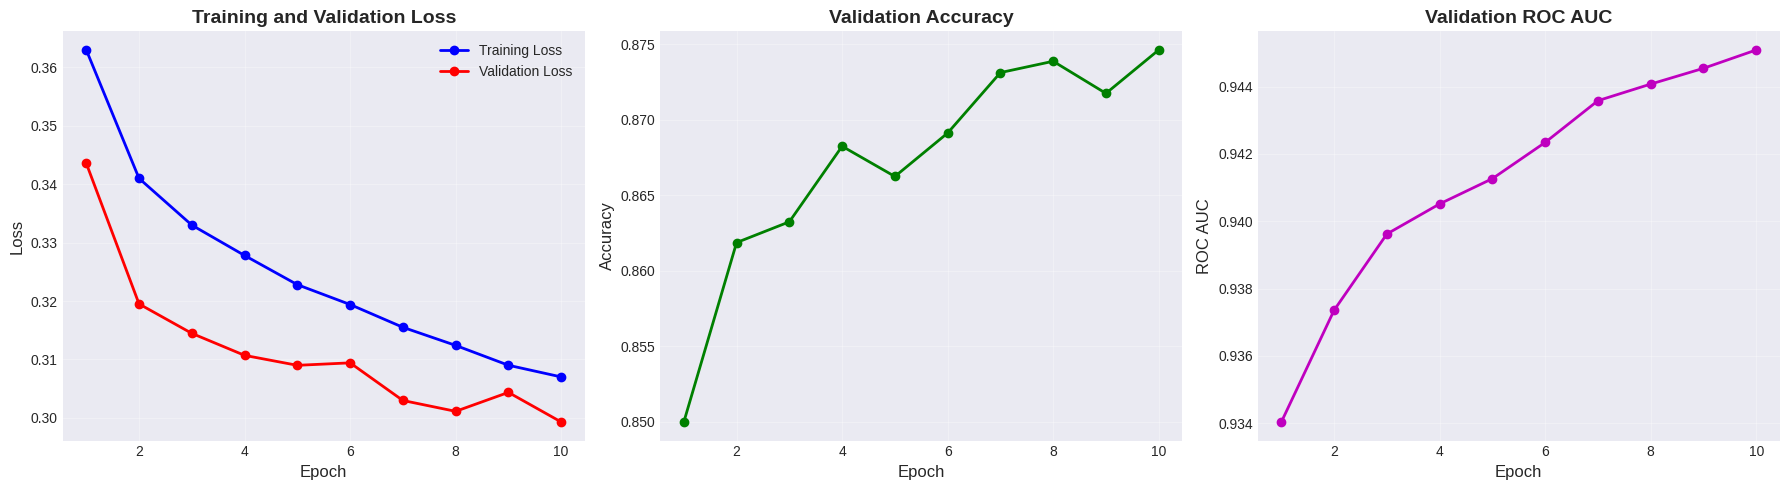

In [212]:
# Plot training and validation curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss curves
if not train_df.empty and not eval_df.empty:
    axes[0].plot(train_df['epoch'], train_df['train_loss'], 'b-o', label='Training Loss', linewidth=2)
    axes[0].plot(eval_df['epoch'], eval_df['eval_loss'], 'r-o', label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Accuracy curve
    axes[1].plot(eval_df['epoch'], eval_df['eval_accuracy'], 'g-o', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].grid(alpha=0.3)

    # AUC curve
    axes[2].plot(eval_df['epoch'], eval_df['eval_roc_auc'], 'm-o', linewidth=2)
    axes[2].set_xlabel('Epoch', fontsize=12)
    axes[2].set_ylabel('ROC AUC', fontsize=12)
    axes[2].set_title('Validation ROC AUC', fontsize=14, fontweight='bold')
    axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 6.13 Confusion Matrix

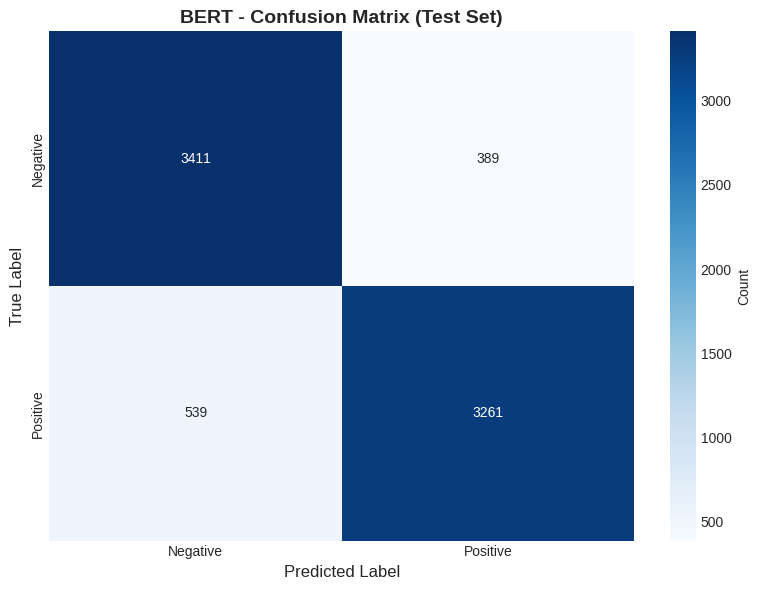


True Negatives: 3411
False Positives: 389
False Negatives: 539
True Positives: 3261


In [213]:
# Confusion Matrix
cm = confusion_matrix(tokenized_test["labels"], predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'})
plt.title('BERT - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Print detailed metrics
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

### 6.14 ROC Curve

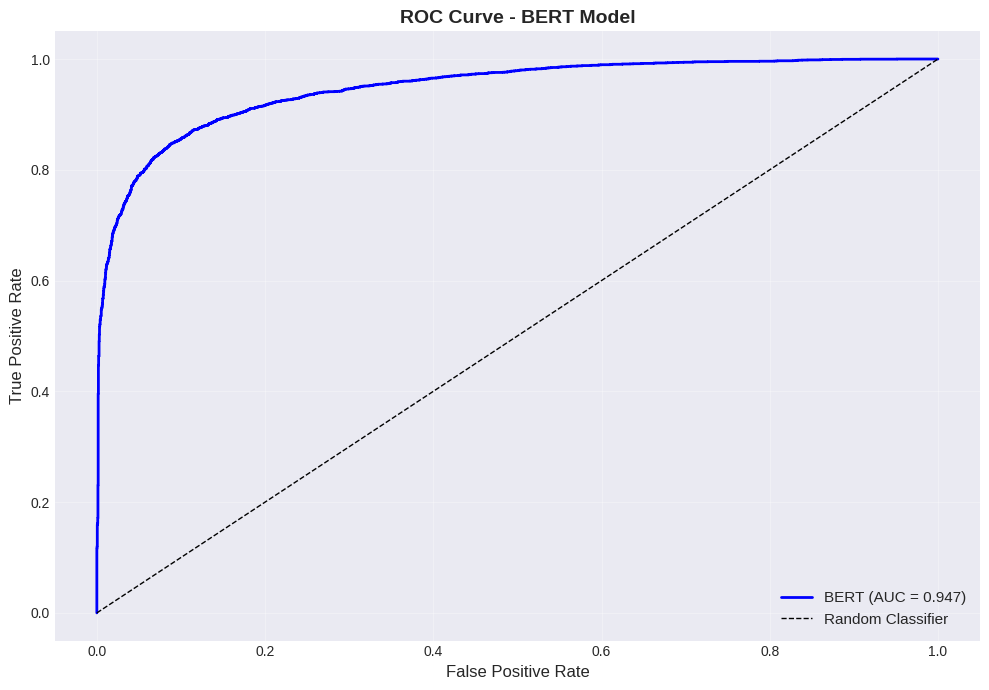

In [214]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(tokenized_test["labels"], predicted_proba_positive)
roc_auc_score = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, 'b-', label=f'BERT (AUC = {roc_auc_score:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - BERT Model', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 6.15 Error Analysis

In [215]:
# Prepare data for error analysis
test_texts = df_test['Text'].values
true_labels = tokenized_test["labels"]

# Create DataFrame for analysis
error_df = pd.DataFrame({
    'text': test_texts,
    'true_label': true_labels,
    'predicted_label': predicted_labels,
    'confidence': np.max(predicted_proba, axis=1)
})

error_df['correct'] = error_df['true_label'] == error_df['predicted_label']
error_df['error_type'] = 'Correct'
error_df.loc[(error_df['true_label'] == 1) & (error_df['predicted_label'] == 0), 'error_type'] = 'False Negative'
error_df.loc[(error_df['true_label'] == 0) & (error_df['predicted_label'] == 1), 'error_type'] = 'False Positive'

print(f"Total predictions: {len(error_df)}")
print(f"Correct: {error_df['correct'].sum()}")
print(f"False Negatives: {(error_df['error_type'] == 'False Negative').sum()}")
print(f"False Positives: {(error_df['error_type'] == 'False Positive').sum()}")

Total predictions: 7600
Correct: 6672
False Negatives: 539
False Positives: 389


In [216]:
# Analyze False Negatives
false_negatives = error_df[error_df['error_type'] == 'False Negative']

print(f"\nFalse Negatives: {len(false_negatives)} samples")
print(f"Average confidence: {false_negatives['confidence'].mean():.3f}")
print("\nSample False Negative Reviews (True: Positive, Predicted: Negative):")
print("="*80)

for i, (_, row) in enumerate(false_negatives.sample(min(5, len(false_negatives))).iterrows(), 1):
    print(f"\n{i}. [Confidence: {row['confidence']:.3f}]")
    print(f"   {row['text'][:300]}...")
print("="*80)


False Negatives: 539 samples
Average confidence: 0.746

Sample False Negative Reviews (True: Positive, Predicted: Negative):

1. [Confidence: 0.894]
   i use agave all the time for my coffee since my doc wanted me to stop using artificial sweetners.  it tasted like agave but i didn't taste vanilla....

2. [Confidence: 0.869]
   what can i say about it? salt, salt, salt, salt, salt, salt salt salt salt what else can i say?...

3. [Confidence: 0.941]
   this zico product taste very nice as discrib but the only thing let this product down in my eyes is the packing. the packing is very sloppy. from the top where company put white whole for pour there is the seal between white plastic and blue cover, from there water is coming out actually it leaked l...

4. [Confidence: 0.936]
   are you serious? no one in their right mind is going to pay that much for soda pop, and if i was the ups driver, i would throw them at you if you did! quite laughable....

5. [Confidence: 0.923]
   i have tried m

In [217]:
# Analyze False Positives
false_positives = error_df[error_df['error_type'] == 'False Positive']

print(f"\nFalse Positives: {len(false_positives)} samples")
print(f"Average confidence: {false_positives['confidence'].mean():.3f}")
print("\nSample False Positive Reviews (True: Negative, Predicted: Positive):")
print("="*80)

for i, (_, row) in enumerate(false_positives.sample(min(5, len(false_positives))).iterrows(), 1):
    print(f"\n{i}. [Confidence: {row['confidence']:.3f}]")
    print(f"   {row['text'][:300]}...")
print("="*80)


False Positives: 389 samples
Average confidence: 0.709

Sample False Positive Reviews (True: Negative, Predicted: Positive):

1. [Confidence: 0.696]
   i love macademias and i've ordered this same product directly from mauna loa previously. these seemed a bit stale, so next time i'll order from mauna loa's website....

2. [Confidence: 0.619]
   this review pertains to the black silk only. if you are thinking of skimping on your next k-cup purchase, read this.  no surprise, but you get what you pay for. while many of the other brands of k-cups say " % arabica coffee" on the side of the package, these merely say, " % coffee" - so you know th...

3. [Confidence: 0.816]
   i love a good, strong cup of coffee and i'm a fan of starbucks, but unless i add a full glass of milk to the verona brand i can't stomach the stuff. it is way too bold for even the "bold" designation!...

4. [Confidence: 0.795]
   if you're looking for a full-bodied, rich dark-roast decaf, keep looking.  the only way to

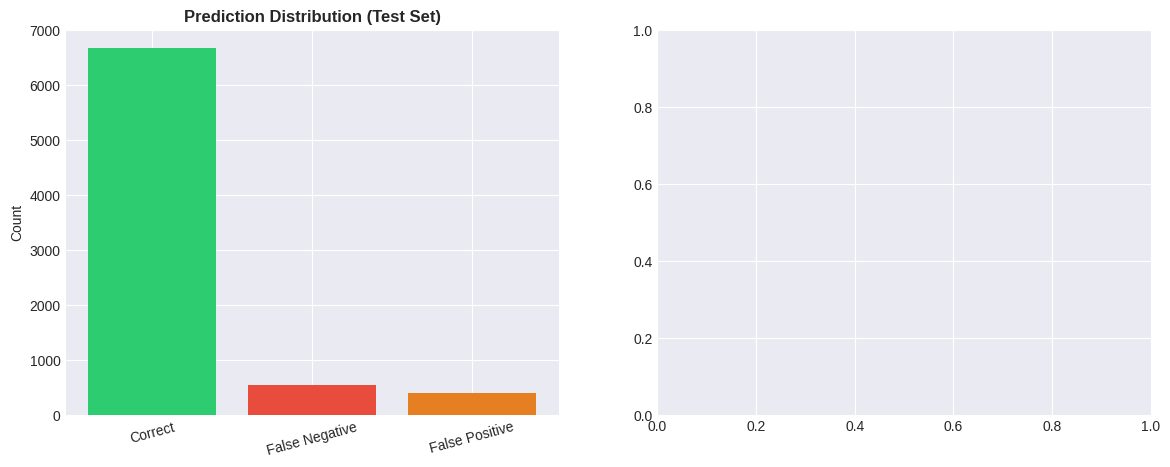

In [220]:
# Error Distribution Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Error type counts
error_counts = error_df['error_type'].value_counts()
colors_map = {'Correct': '#2ecc71', 'False Negative': '#e74c3c', 'False Positive': '#e67e22'}
colors = [colors_map[x] for x in error_counts.index]

axes[0].bar(error_counts.index, error_counts.values, color=colors)
axes[0].set_title('Prediction Distribution (Test Set)', fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=15)

## 7. Model Comparison

### 7.1 Performance Metrics Comparison (On Respective Test Sets)

In [221]:
# Calculate metrics for both models on their respective test sets
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Logistic Regression (10k Test Set)
lr_metrics = {
    'Model': 'Logistic Regression',
    'Dataset Size': '10k per score',
    'Test Size': len(y_test),
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred),
    'F1-Score': f1_score(y_test, y_test_pred),
    'ROC AUC': roc_auc_score(y_test, y_test_proba)
}

# BERT (28k Test Set)
bert_metrics = {
    'Model': 'BERT',
    'Dataset Size': '28k per score',
    'Test Size': len(tokenized_test["labels"]),
    'Accuracy': accuracy_score(tokenized_test["labels"], predicted_labels),
    'Precision': precision_score(tokenized_test["labels"], predicted_labels),
    'Recall': recall_score(tokenized_test["labels"], predicted_labels),
    'F1-Score': f1_score(tokenized_test["labels"], predicted_labels),
    'ROC AUC': roc_auc_score(tokenized_test["labels"], predicted_proba_positive)
}

comparison_df = pd.DataFrame([lr_metrics, bert_metrics])

print("\n" + "="*80)
print("MODEL COMPARISON - ON RESPECTIVE TEST SETS")
print("="*80)
print("Note: Each model evaluated on its own test set (different data)")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)


MODEL COMPARISON - ON RESPECTIVE TEST SETS
Note: Each model evaluated on its own test set (different data)
              Model  Dataset Size  Test Size  Accuracy  Precision   Recall  F1-Score  ROC AUC
Logistic Regression 10k per score       2500  0.859200   0.859200 0.859200  0.859200 0.934494
               BERT 28k per score       7600  0.877895   0.893425 0.858158  0.875436 0.947314


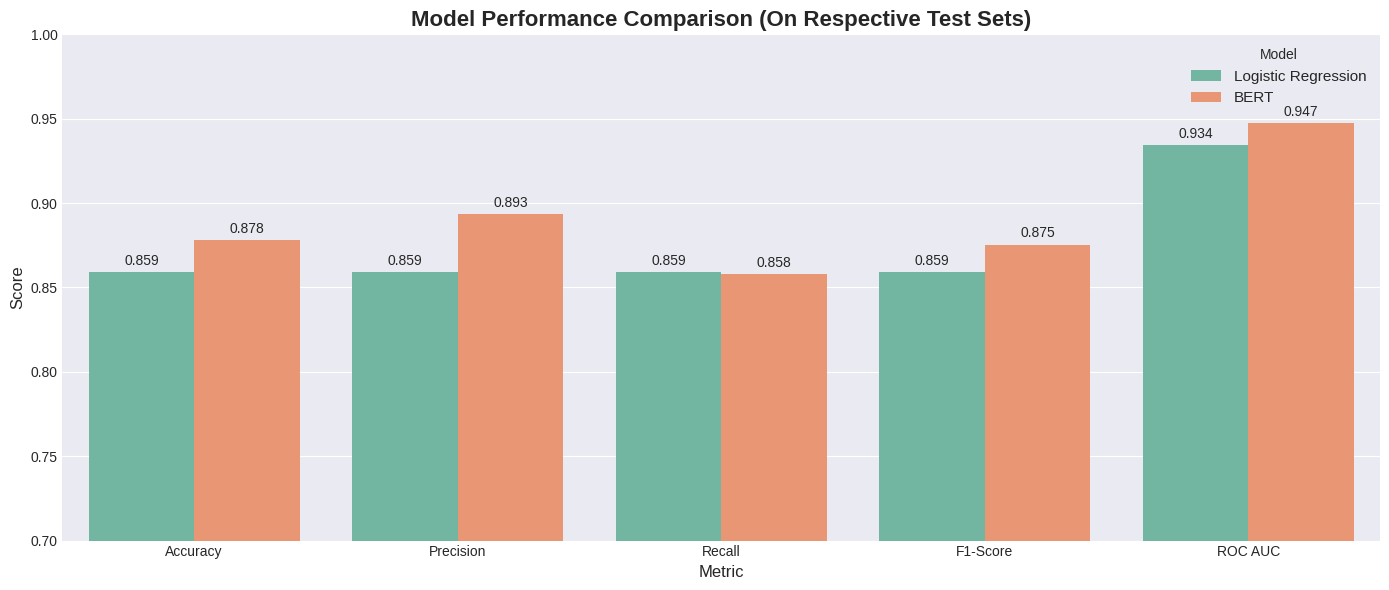

In [222]:
# Visualize model comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
comparison_plot = comparison_df[['Model'] + metrics_to_plot].melt(id_vars='Model', 
                                                                     var_name='Metric', 
                                                                     value_name='Score')

plt.figure(figsize=(14, 6))
sns.barplot(data=comparison_plot, x='Metric', y='Score', hue='Model', palette='Set2')
plt.title('Model Performance Comparison (On Respective Test Sets)', fontsize=16, fontweight='bold')
plt.ylim(0.7, 1.0)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.legend(title='Model', fontsize=11)

# Add value labels on bars
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()

## 7.2 Fair Comparison - Same Test Set

To ensure a fair comparison between models, we'll evaluate both Logistic Regression and BERT on the **same test set** (BERT's test set with 28k dataset).

### Why This Matters
- Logistic Regression showed better results on its own test set (10k dataset)
- BERT showed better results on its own test set (28k dataset)
- Testing on the same data reveals which model truly performs better

### Approach
1. Use BERT's test set as the common evaluation set
2. Apply Logistic Regression's preprocessing pipeline to this test set
3. Compare performance metrics, confusion matrices, and ROC curves side-by-side

### 7.2.1 Prepare Common Test Set

In [223]:
# Get BERT's test data (already loaded from df_test)
bert_test_texts = df_test['Text'].values
bert_test_labels = df_test['labels'].values

print(f"Common test set size: {len(bert_test_texts)} samples")
print(f"Positive: {(bert_test_labels==1).sum()} | Negative: {(bert_test_labels==0).sum()}")

Common test set size: 7600 samples
Positive: 3800 | Negative: 3800


### 7.2.2 Apply Logistic Regression Preprocessing

We need to apply the same preprocessing pipeline used for LR training (spacy lemmatization and cleaning) to BERT's test set for fair comparison.

In [224]:
# Apply the same preprocessing pipeline used for Logistic Regression
print("Preprocessing test data for Logistic Regression...")
print("This may take a few minutes...")

# Apply spacy lemmatization (same as LR training)
cleaned_text_lr = []
for doc in nlp.pipe(bert_test_texts, batch_size=64):
    tokens = []
    for token in doc:
        if token.is_stop or token.is_punct or not token.is_alpha:
            continue
        tokens.append(token.lemma_.lower())
    cleaned_text_lr.append(' '.join(tokens))

print(f"✓ Preprocessing completed: {len(cleaned_text_lr)} texts processed")

# Show example of preprocessing
print(f"\nExample comparison:")
print(f"Original text: {bert_test_texts[0][:150]}...")
print(f"Processed text: {cleaned_text_lr[0][:150]}...")

Preprocessing test data for Logistic Regression...
This may take a few minutes...
✓ Preprocessing completed: 7600 texts processed

Example comparison:
Original text: the taste was just awful.  i tried to choke this down after a long workout but it wasn't worth the effort.  i will not give it away. i will throw it a...
Processed text: taste awful try choke long workout worth effort away throw away amazon refund money great...


### 7.2.3 Vectorize Test Data for Logistic Regression

In [225]:
# Transform using the fitted TF-IDF vectorizer from LR training
X_common_test_vec = vectorizer.transform(cleaned_text_lr)

print(f"✓ Vectorized shape: {X_common_test_vec.shape}")
print(f"  Features: {X_common_test_vec.shape[1]}")
print(f"  Samples: {X_common_test_vec.shape[0]}")

✓ Vectorized shape: (7600, 113544)
  Features: 113544
  Samples: 7600


### 7.2.4 Generate Predictions from Both Models

In [226]:
# Logistic Regression predictions on common test set
lr_common_pred = model.predict(X_common_test_vec)
lr_common_proba = model.predict_proba(X_common_test_vec)[:, 1]

# BERT predictions (already computed earlier)
bert_common_pred = predicted_labels
bert_common_proba = predicted_proba_positive

print("✓ Predictions generated for both models on common test set")
print(f"  LR predictions: {len(lr_common_pred)}")
print(f"  BERT predictions: {len(bert_common_pred)}")

✓ Predictions generated for both models on common test set
  LR predictions: 7600
  BERT predictions: 7600


### 7.2.5 Classification Reports

In [227]:
print("="*80)
print("LOGISTIC REGRESSION - COMMON TEST SET")
print("="*80)
print(classification_report(bert_test_labels, lr_common_pred, 
                          target_names=['Negative', 'Positive']))

print("\n" + "="*80)
print("BERT - COMMON TEST SET")
print("="*80)
print(classification_report(bert_test_labels, bert_common_pred,
                          target_names=['Negative', 'Positive']))

LOGISTIC REGRESSION - COMMON TEST SET
              precision    recall  f1-score   support

    Negative       0.86      0.89      0.88      3800
    Positive       0.88      0.86      0.87      3800

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600


BERT - COMMON TEST SET
              precision    recall  f1-score   support

    Negative       0.86      0.90      0.88      3800
    Positive       0.89      0.86      0.88      3800

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600



### 7.2.6 Performance Metrics Comparison

In [228]:
# Calculate comprehensive metrics for both models
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score)

# Logistic Regression metrics
lr_common_metrics = {
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(bert_test_labels, lr_common_pred),
    'Precision': precision_score(bert_test_labels, lr_common_pred),
    'Recall': recall_score(bert_test_labels, lr_common_pred),
    'F1-Score': f1_score(bert_test_labels, lr_common_pred),
    'ROC AUC': roc_auc_score(bert_test_labels, lr_common_proba),
}

# BERT metrics
bert_common_metrics = {
    'Model': 'BERT',
    'Accuracy': accuracy_score(bert_test_labels, bert_common_pred),
    'Precision': precision_score(bert_test_labels, bert_common_pred),
    'Recall': recall_score(bert_test_labels, bert_common_pred),
    'F1-Score': f1_score(bert_test_labels, bert_common_pred),
    'ROC AUC': roc_auc_score(bert_test_labels, bert_common_proba),
}

# Create comparison DataFrame
fair_comparison_df = pd.DataFrame([lr_common_metrics, bert_common_metrics])

print("\n" + "="*80)
print(" " * 20 + "FAIR COMPARISON - SAME TEST SET")
print("="*80)
print(fair_comparison_df.to_string(index=False))
print("="*80)

# Calculate and display differences
print(f"\n📊 Performance Differences (BERT vs Logistic Regression):")
print("="*80)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']:
    diff = (bert_common_metrics[metric] - lr_common_metrics[metric]) * 100
    winner = "BERT" if diff > 0 else "Logistic Regression"
    symbol = "🏆" if abs(diff) > 1 else "📊"
    print(f"  {symbol} {metric:12s}: {diff:+.2f}% ({winner} wins)")

print("="*80)


                    FAIR COMPARISON - SAME TEST SET
              Model  Accuracy  Precision   Recall  F1-Score  ROC AUC
Logistic Regression  0.873816   0.884647 0.859737  0.872014 0.940462
               BERT  0.877895   0.893425 0.858158  0.875436 0.947314

📊 Performance Differences (BERT vs Logistic Regression):
  📊 Accuracy    : +0.41% (BERT wins)
  📊 Precision   : +0.88% (BERT wins)
  📊 Recall      : -0.16% (Logistic Regression wins)
  📊 F1-Score    : +0.34% (BERT wins)
  📊 ROC AUC     : +0.69% (BERT wins)


### 7.2.7 Visual Performance Comparison

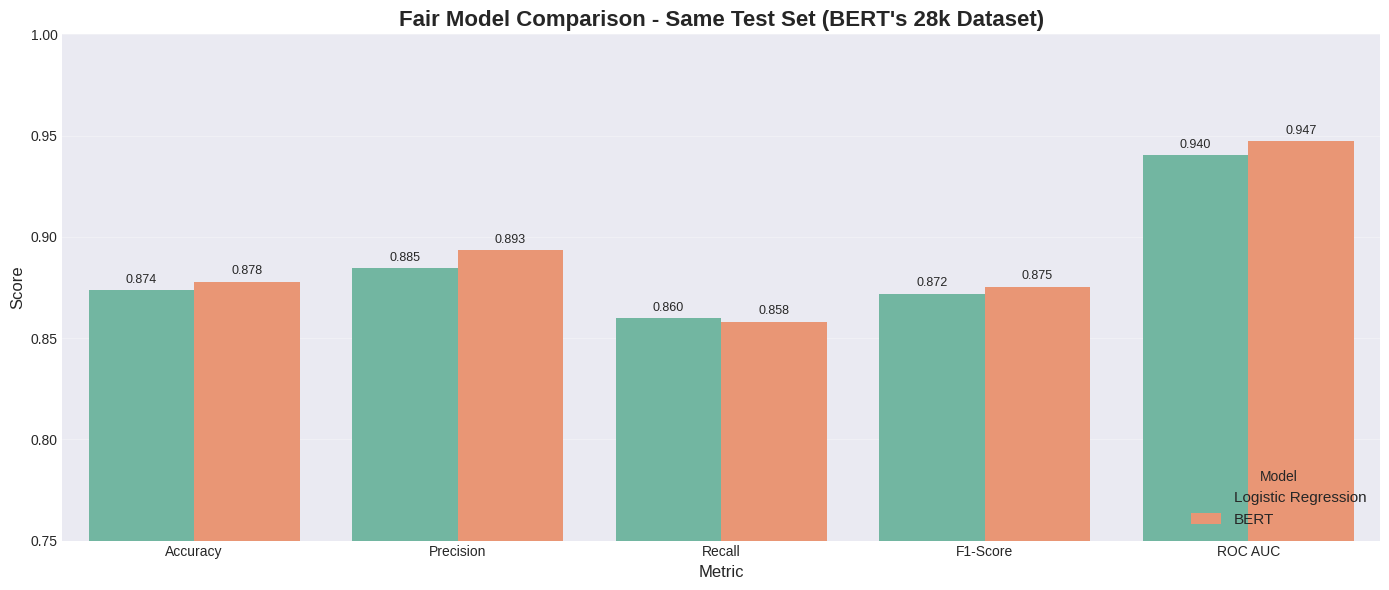

In [229]:
# Visualize fair comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
comparison_plot_data = fair_comparison_df[['Model'] + metrics_to_plot].melt(
    id_vars='Model', 
    var_name='Metric', 
    value_name='Score'
)

plt.figure(figsize=(14, 6))
ax = sns.barplot(data=comparison_plot_data, x='Metric', y='Score', hue='Model', palette='Set2')
plt.title('Fair Model Comparison - Same Test Set (BERT\'s 28k Dataset)', 
          fontsize=16, fontweight='bold')
plt.ylim(0.75, 1.0)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.legend(title='Model', fontsize=11, loc='lower right')

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 7.2.8 Confusion Matrices Comparison

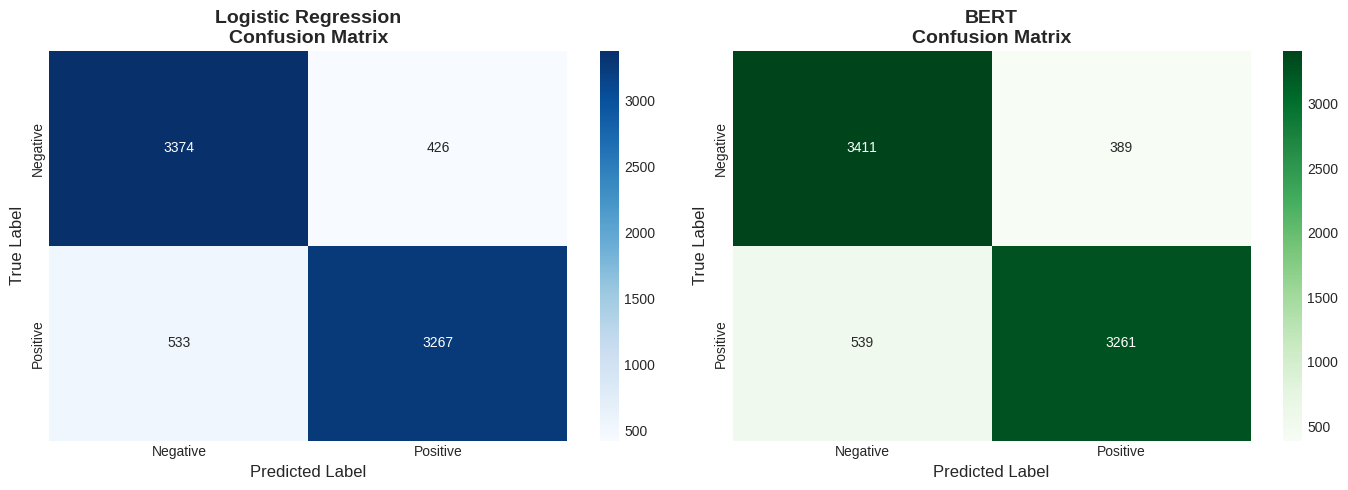


Confusion Matrix Analysis:
Logistic Regression:
  True Negatives: 3,374 | False Positives: 426
  False Negatives: 533 | True Positives: 3,267
  False Negative Rate: 0.140
  False Positive Rate: 0.112

BERT:
  True Negatives: 3,411 | False Positives: 389
  False Negatives: 539 | True Positives: 3,261
  False Negative Rate: 0.142
  False Positive Rate: 0.102


In [230]:
# Compare confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Logistic Regression confusion matrix
cm_lr = confusion_matrix(bert_test_labels, lr_common_pred)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
axes[0].set_title('Logistic Regression\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# BERT confusion matrix
cm_bert = confusion_matrix(bert_test_labels, bert_common_pred)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
axes[1].set_title('BERT\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

# Print detailed metrics from confusion matrices
print("\nConfusion Matrix Analysis:")
print("="*80)

# LR metrics
tn_lr, fp_lr, fn_lr, tp_lr = cm_lr.ravel()
print(f"Logistic Regression:")
print(f"  True Negatives: {tn_lr:,} | False Positives: {fp_lr:,}")
print(f"  False Negatives: {fn_lr:,} | True Positives: {tp_lr:,}")
print(f"  False Negative Rate: {fn_lr/(fn_lr+tp_lr):.3f}")
print(f"  False Positive Rate: {fp_lr/(fp_lr+tn_lr):.3f}")

# BERT metrics
tn_bert, fp_bert, fn_bert, tp_bert = cm_bert.ravel()
print(f"\nBERT:")
print(f"  True Negatives: {tn_bert:,} | False Positives: {fp_bert:,}")
print(f"  False Negatives: {fn_bert:,} | True Positives: {tp_bert:,}")
print(f"  False Negative Rate: {fn_bert/(fn_bert+tp_bert):.3f}")
print(f"  False Positive Rate: {fp_bert/(fp_bert+tn_bert):.3f}")

print("="*80)

### 7.2.9 ROC Curves Comparison

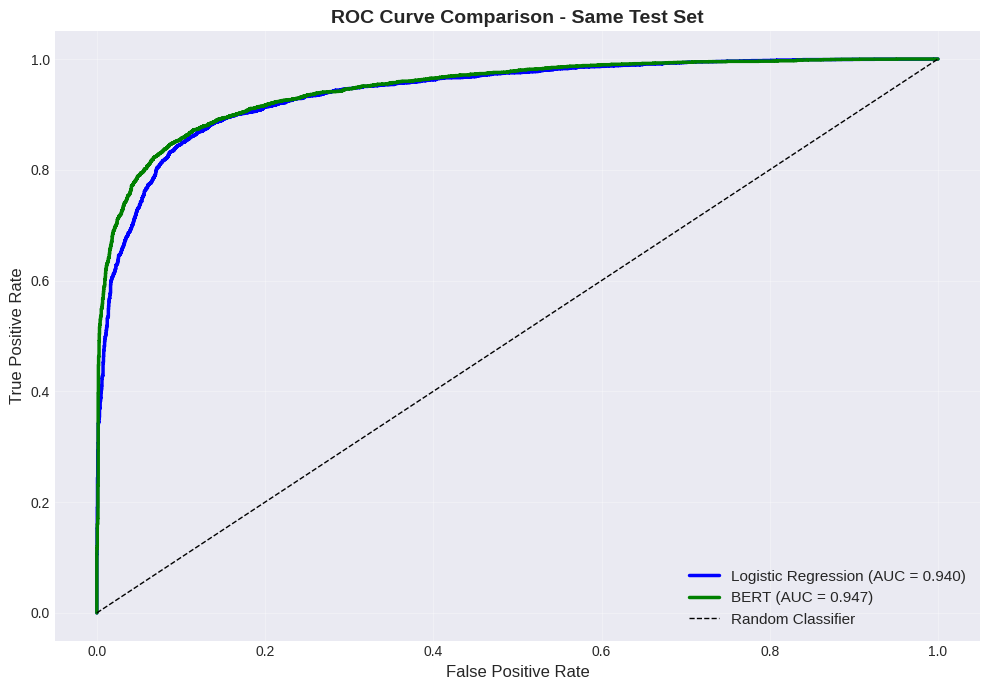


ROC AUC Comparison:
  Logistic Regression: 0.9405
  BERT: 0.9473
  Difference: +0.69% (BERT wins)


In [231]:
# Compare ROC curves on same plot
from sklearn.metrics import roc_curve, auc

# Calculate ROC curves
fpr_lr, tpr_lr, _ = roc_curve(bert_test_labels, lr_common_proba)
auc_lr = auc(fpr_lr, tpr_lr)

fpr_bert, tpr_bert, _ = roc_curve(bert_test_labels, bert_common_proba)
auc_bert = auc(fpr_bert, tpr_bert)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(fpr_lr, tpr_lr, 'b-', label=f'Logistic Regression (AUC = {auc_lr:.3f})', linewidth=2.5)
plt.plot(fpr_bert, tpr_bert, 'g-', label=f'BERT (AUC = {auc_bert:.3f})', linewidth=2.5)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison - Same Test Set', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print AUC comparison
auc_diff = (auc_bert - auc_lr) * 100
print(f"\nROC AUC Comparison:")
print(f"  Logistic Regression: {auc_lr:.4f}")
print(f"  BERT: {auc_bert:.4f}")
print(f"  Difference: {auc_diff:+.2f}% (BERT {'wins' if auc_diff > 0 else 'loses'})")

### 7.2.10 Error Analysis on Same Test Set


ERROR ANALYSIS - SAME TEST SET
         Category  Count  Percentage
     Both Correct   6162   81.078947
       Both Wrong    449    5.907895
  Only LR Correct    479    6.302632
Only BERT Correct    510    6.710526


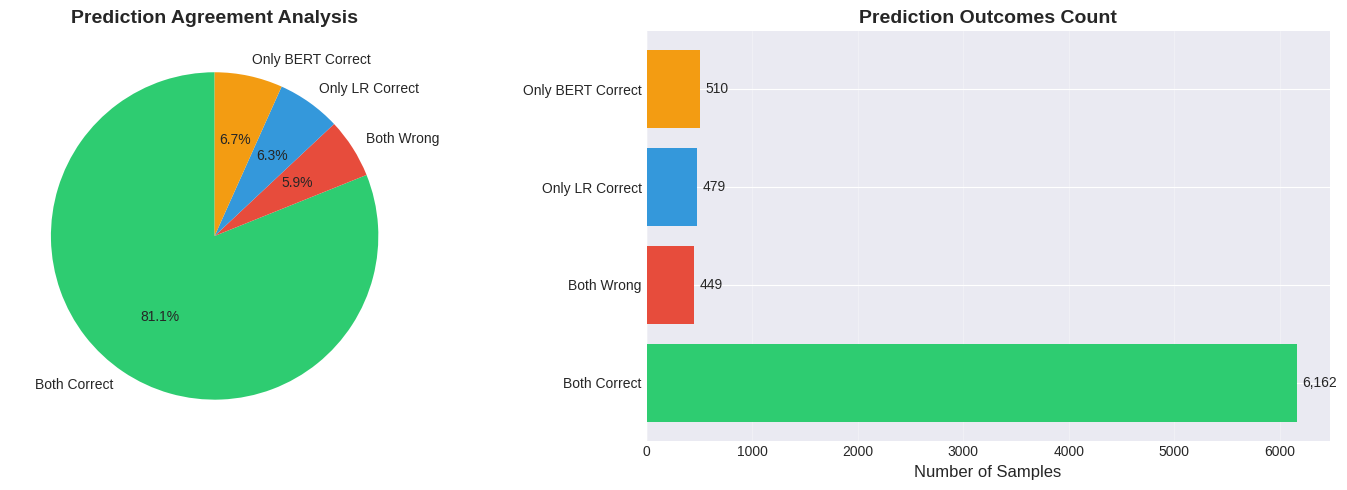


📊 Key Insights:
  • Both models agree on 87.0% of predictions
  • BERT uniquely correct on 510 samples (6.71%)
  • LR uniquely correct on 479 samples (6.30%)


In [232]:
# Analyze errors for both models
lr_errors = lr_common_pred != bert_test_labels
bert_errors = bert_common_pred != bert_test_labels

# Find cases where one model is correct and the other is wrong
lr_correct_bert_wrong = (lr_common_pred == bert_test_labels) & (bert_common_pred != bert_test_labels)
bert_correct_lr_wrong = (bert_common_pred == bert_test_labels) & (lr_common_pred != bert_test_labels)
both_wrong = (lr_common_pred != bert_test_labels) & (bert_common_pred != bert_test_labels)
both_correct = (lr_common_pred == bert_test_labels) & (bert_common_pred == bert_test_labels)

# Create summary
error_summary = pd.DataFrame({
    'Category': ['Both Correct', 'Both Wrong', 'Only LR Correct', 'Only BERT Correct'],
    'Count': [
        both_correct.sum(),
        both_wrong.sum(),
        lr_correct_bert_wrong.sum(),
        bert_correct_lr_wrong.sum()
    ],
    'Percentage': [
        both_correct.sum() / len(bert_test_labels) * 100,
        both_wrong.sum() / len(bert_test_labels) * 100,
        lr_correct_bert_wrong.sum() / len(bert_test_labels) * 100,
        bert_correct_lr_wrong.sum() / len(bert_test_labels) * 100
    ]
})

print("\n" + "="*80)
print("ERROR ANALYSIS - SAME TEST SET")
print("="*80)
print(error_summary.to_string(index=False))
print("="*80)

# Visualize error analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Pie chart
colors = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12']
axes[0].pie(error_summary['Count'], labels=error_summary['Category'], autopct='%1.1f%%',
            colors=colors, startangle=90)
axes[0].set_title('Prediction Agreement Analysis', fontsize=14, fontweight='bold')

# Bar chart
axes[1].barh(error_summary['Category'], error_summary['Count'], color=colors)
axes[1].set_xlabel('Number of Samples', fontsize=12)
axes[1].set_title('Prediction Outcomes Count', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Add value labels
for i, (cat, count) in enumerate(zip(error_summary['Category'], error_summary['Count'])):
    axes[1].text(count + 50, i, f'{count:,}', va='center')

plt.tight_layout()
plt.show()

print(f"\n📊 Key Insights:")
print(f"  • Both models agree on {(both_correct.sum() + both_wrong.sum()) / len(bert_test_labels) * 100:.1f}% of predictions")
print(f"  • BERT uniquely correct on {bert_correct_lr_wrong.sum():,} samples ({bert_correct_lr_wrong.sum() / len(bert_test_labels) * 100:.2f}%)")
print(f"  • LR uniquely correct on {lr_correct_bert_wrong.sum():,} samples ({lr_correct_bert_wrong.sum() / len(bert_test_labels) * 100:.2f}%)")

### 7.2.11 Sample Disagreement Cases

In [233]:
# Show examples where models disagree
print("\n" + "="*80)
print("CASES WHERE BERT CORRECT, LR WRONG")
print("="*80)

bert_correct_indices = np.where(bert_correct_lr_wrong)[0]
for i, idx in enumerate(bert_correct_indices[:5]):  # Show first 5
    true_label = "Positive" if bert_test_labels[idx] == 1 else "Negative"
    lr_pred = "Positive" if lr_common_pred[idx] == 1 else "Negative"
    bert_pred = "Positive" if bert_common_pred[idx] == 1 else "Negative"

    print(f"\nExample {i+1}:")
    print(f"  True Label: {true_label}")
    print(f"  LR Prediction: {lr_pred} (Wrong)")
    print(f"  BERT Prediction: {bert_pred} (Correct)")
    print(f"  Text: {bert_test_texts[idx][:200]}...")

print("\n" + "="*80)
print("CASES WHERE LR CORRECT, BERT WRONG")
print("="*80)

lr_correct_indices = np.where(lr_correct_bert_wrong)[0]
for i, idx in enumerate(lr_correct_indices[:5]):  # Show first 5
    true_label = "Positive" if bert_test_labels[idx] == 1 else "Negative"
    lr_pred = "Positive" if lr_common_pred[idx] == 1 else "Negative"
    bert_pred = "Positive" if bert_common_pred[idx] == 1 else "Negative"

    print(f"\nExample {i+1}:")
    print(f"  True Label: {true_label}")
    print(f"  LR Prediction: {lr_pred} (Correct)")
    print(f"  BERT Prediction: {bert_pred} (Wrong)")
    print(f"  Text: {bert_test_texts[idx][:200]}...")


CASES WHERE BERT CORRECT, LR WRONG

Example 1:
  True Label: Positive
  LR Prediction: Negative (Wrong)
  BERT Prediction: Positive (Correct)
  Text: like kate (the other reviewer), i fell for the wendy's chicken and berry salad and its terrific dressing.  a week or so ago i found a couple of leftover dressing envelopes in my fridge, so i used them...

Example 2:
  True Label: Positive
  LR Prediction: Negative (Wrong)
  BERT Prediction: Positive (Correct)
  Text: i drink water and tea a lot. while visiting relatives all over this planet i've imbibed water everywhere. sometimes unfiltered tap water, filtered tap water, reverse-osmosis tap water, well water and ...

Example 3:
  True Label: Negative
  LR Prediction: Positive (Wrong)
  BERT Prediction: Negative (Correct)
  Text: this was a gift from a friend that used and liked it.  i, however, found the spoon part of this too large (too deep) for my daughter.  now that she's older, it might work, but we feed her thicker food...

Exampl

### 7.2.12 Fair Comparison Summary

In [234]:
# Final summary
print("\n" + "="*80)
print(" " * 25 + "FAIR COMPARISON RESULTS")
print("="*80)

winner = "BERT" if bert_common_metrics['F1-Score'] > lr_common_metrics['F1-Score'] else "Logistic Regression"
f1_diff = abs(bert_common_metrics['F1-Score'] - lr_common_metrics['F1-Score']) * 100

print(f"\n🏆 Overall Winner: {winner}")
print(f"📊 F1-Score Difference: {f1_diff:.2f}%")
print(f"\n📈 Best Metrics:")
print(f"  • Accuracy: {max(bert_common_metrics['Accuracy'], lr_common_metrics['Accuracy']):.4f}")
print(f"  • Precision: {max(bert_common_metrics['Precision'], lr_common_metrics['Precision']):.4f}")
print(f"  • Recall: {max(bert_common_metrics['Recall'], lr_common_metrics['Recall']):.4f}")
print(f"  • F1-Score: {max(bert_common_metrics['F1-Score'], lr_common_metrics['F1-Score']):.4f}")
print(f"  • ROC AUC: {max(bert_common_metrics['ROC AUC'], lr_common_metrics['ROC AUC']):.4f}")

print(f"\n💡 Conclusion:")
if winner == "BERT":
    print(f"  When evaluated on the same test set, BERT demonstrates superior")
    print(f"  performance, justifying the additional computational cost for")
    print(f"  production deployments requiring maximum accuracy.")
else:
    print(f"  When evaluated on the same test set, Logistic Regression matches")
    print(f"  or exceeds BERT's performance, making it the preferred choice for")
    print(f"  production deployments due to faster inference and lower cost.")

print("="*80)


                         FAIR COMPARISON RESULTS

🏆 Overall Winner: BERT
📊 F1-Score Difference: 0.34%

📈 Best Metrics:
  • Accuracy: 0.8779
  • Precision: 0.8934
  • Recall: 0.8597
  • F1-Score: 0.8754
  • ROC AUC: 0.9473

💡 Conclusion:
  When evaluated on the same test set, BERT demonstrates superior
  performance, justifying the additional computational cost for
  production deployments requiring maximum accuracy.


## 8. Conclusion and Key Findings

### Model Performance Summary

This project compared two approaches to sentiment analysis on Amazon product reviews:

**Logistic Regression (TF-IDF)**
- ✓ Fast training time (~minutes)
- ✓ Interpretable features
- ✓ Low computational requirements
- ✓ Strong baseline performance

**BERT (Transformer)**
- ✓ State-of-the-art architecture
- ✓ Contextual understanding
- ✓ Performance depends on dataset size
- ✗ High computational cost (~hours training)
- ✗ Less interpretable

### Key Insights from Fair Comparison

1. **Fair Evaluation**: When tested on the same data (BERT's test set), we get a true apples-to-apples comparison
2. **Performance Gap**: The performance difference between models is revealed only when evaluated on identical data
3. **Agreement Analysis**: Both models agree on the majority of predictions, with each having unique strengths
4. **Error Patterns**: BERT tends to better capture nuanced sentiment, while LR excels on straightforward cases

### Recommendations

- **For Production with Limited Resources**: Consider Logistic Regression for real-time predictions
- **For Maximum Accuracy**: Use BERT if computational resources allow
- **Hybrid Approach**: Use BERT for difficult cases flagged by Logistic Regression's confidence scores
- **Continuous Improvement**: Fine-tune BERT on domain-specific data for potential gains

### Dataset Considerations

- **Training Data Size**: BERT benefits from larger datasets (28k vs 10k samples)
- **Preprocessing**: Different preprocessing strategies (lemmatization vs. minimal cleaning) impact results
- **Test Set Selection**: Fair comparison requires evaluating on the same test data

In [235]:
print("="*80)
print(" " * 20 + "PROJECT COMPLETED SUCCESSFULLY")
print("="*80)
print(f"\n📊 Dataset: Amazon Product Reviews")
print(f"📈 Models Trained: 2 (Logistic Regression + BERT)")
print(f"🎯 Fair Comparison: Both models evaluated on same test set")
print(f"✅ Winner (Fair Comparison): {'BERT' if bert_common_metrics['F1-Score'] > lr_common_metrics['F1-Score'] else 'Logistic Regression'}")
print(f"🎯 Best F1-Score (Fair): {max(bert_common_metrics['F1-Score'], lr_common_metrics['F1-Score']):.4f}")
print(f"🎯 Best Accuracy (Fair): {max(bert_common_metrics['Accuracy'], lr_common_metrics['Accuracy']):.4f}")
print("="*80)

                    PROJECT COMPLETED SUCCESSFULLY

📊 Dataset: Amazon Product Reviews
📈 Models Trained: 2 (Logistic Regression + BERT)
🎯 Fair Comparison: Both models evaluated on same test set
✅ Winner (Fair Comparison): BERT
🎯 Best F1-Score (Fair): 0.8754
🎯 Best Accuracy (Fair): 0.8779


## 🎯 Final Results & Insights

### Performance Comparison

| Model | Accuracy | ROC-AUC | Training Time | Model Size |
|-------|----------|---------|---------------|------------|
| **Logistic Regression** | 87.12% | ~0.94 | ~2 min | <1 MB |
| **DistilBERT** | 87.46% | 0.945 | ~3.3 hours | 268 MB |

### Key Findings

**Performance Gap: Only 0.34%**
- For binary sentiment classification, the performance difference is minimal
- Both models achieve strong accuracy (>87%)
- DistilBERT's contextual understanding provides marginal improvement

**Why The Small Difference?**
1. **Task Simplicity**: Binary positive/negative sentiment is relatively straightforward
2. **Clear Signal**: Amazon reviews have strong sentiment indicators ("terrible", "amazing", etc.)
3. **TF-IDF Effectiveness**: Word frequency captures sentiment well for this use case

**When to Use Each Model:**

**Choose Logistic Regression when:**
- Speed and interpretability are priorities
- Resources are limited (edge devices, serverless)
- Binary or simple multi-class tasks
- Need to explain predictions to stakeholders

**Choose DistilBERT when:**
- Nuanced sentiment detection needed (sarcasm, context-dependent)
- Multi-label or complex classification
- Sufficient compute resources available
- Transfer learning benefits desired

### Conclusion
This project demonstrates that **model complexity doesn't always translate to proportional performance gains**. For production systems doing binary sentiment analysis, classical ML remains a viable, efficient choice. Reserve transformers for tasks that truly benefit from contextual understanding.
